## Design of a simple relation dataset

Goal of this NB:
* Investigate various possibilities of creating a synthetic dataset of simple relations
* Implement a dataset generator with varying levels of complexity, e.g.
    * Parametrize scale differences, add noise to object or background, add noise to orientation
    
Before coding anything, paper design is required. Explore:
* Possible representation of object
* What kind of network will be applied to it
    * What are the inputs and outputs
    * What is the architecture? Is it broken into multiple steps, or one feed forward chonker?
    * How to evaluate performance, and how to train?
        * Will training be supervised, or unsupervised? If unsupervised, then how?
        * Evaluation must be supervised... right?
        
Coding quandries:
* How to render objects?
    * PIL or Matplotlib? Or is there something else? OPEN CV DUUUH
* Write a simple two object generator first to get a feel for the limitations? Bash it out before lunch!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
def show_np_canvas(canvas):
    plt.imshow(canvas)

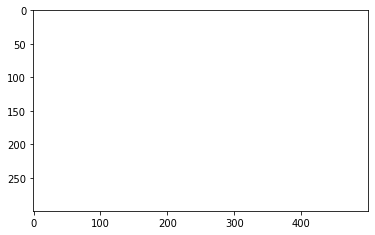

In [3]:
canvas_size = (300,500,3)
canvas = np.ones(canvas_size)
show_np_canvas(canvas)

centre: (135, 91), angle 0.0


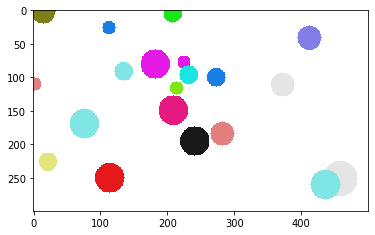

In [13]:
# add some objects
def get_random_pos(bounds):
    pass

def generate_dude(canvas):
    cs = canvas.shape
    
    size = np.random.choice(range(10,30,4))
    pos = (np.random.rand(2) * cs[:2]).astype('int32')
    pos[0], pos[1] = pos[1], pos[0]
    pos = tuple(pos)
    # draw body
    col = [np.random.choice([0.1,0.5, 0.9]) for x in range(3)]
    cv2.circle(canvas, pos, size, thickness=-1, color=col)
    
    # draw nose
    angle = np.random.choice(np.linspace(0,2*np.pi,8))
    pos2 = (int(pos[0]+(size+10)*np.cos(angle)), int(pos[1]-(size+10)*np.sin(angle)))
    print(f'centre: {pos}, angle {angle*180/np.pi}')
    #cv2.line(canvas, pos, pos2, thickness=int(np.sqrt(size)), color=col)
    dudevars = {'col': col, 'size': size, 'pos':pos}
    return dudevars
    
    
generate_dude(canvas)
show_np_canvas(canvas)

centre: (225, 100), angle 0.0
centre: (458, 20), angle 205.71428571428572
centre: (300, 72), angle 51.42857142857143
centre: (159, 28), angle 102.85714285714286
centre: (215, 183), angle 308.5714285714286
centre: (298, 280), angle 51.42857142857143
centre: (50, 22), angle 154.2857142857143
centre: (306, 70), angle 308.5714285714286
centre: (11, 139), angle 51.42857142857143
centre: (194, 206), angle 102.85714285714286
centre: (486, 200), angle 51.42857142857143
centre: (300, 196), angle 0.0
centre: (26, 37), angle 308.5714285714286
centre: (389, 267), angle 205.71428571428572
centre: (436, 189), angle 154.2857142857143
centre: (350, 283), angle 51.42857142857143
centre: (249, 65), angle 51.42857142857143
centre: (378, 113), angle 51.42857142857143
centre: (235, 277), angle 205.71428571428572
centre: (128, 0), angle 308.5714285714286


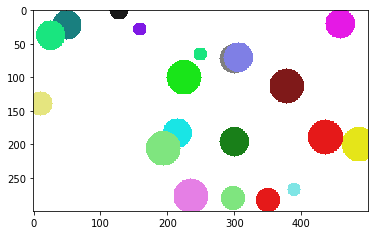

In [14]:
canvas = np.ones(canvas_size)
for i in range(20):
    generate_dude(canvas)
    
show_np_canvas(canvas)

In [588]:
class Element:
    
    def __init__(self, elements, bounds, paired_init=False, sizes=range(10,30,5), set_id=None):
        bounds = list(bounds)
        bounds[0], bounds[1] = bounds[1], bounds[0]
        self.bounds = bounds
        
        self.size = np.random.choice(sizes)
        #self.col = [np.random.choice([0.2,0.4, 0.8, 0.5, 0.9]) for x in range(3)]
        self.col = [1, 1, 1]
        
        self.partner = None
        self.bbox = None
        self.position = None
        
        if set_id is not None:
            self.id = set_id
        else:
            if len(elements) > 0:
                self.id = max([e.id for e in elements]) + 1
                if not paired_init:
                    self.partner = np.random.choice(elements+[None, None, None, None])
            else:
                self.id = 0

        self._set_random_position_and_bbox(elements)
        self._set_orientation()
        
    def draw(self, canvas, draw_bbox=False):
        # draw body
        cv2.circle(canvas, self.position, self.size, thickness=-1, color=self.col, lineType=cv2.LINE_AA)
        # draw nose
        cv2.line(canvas, self.position, self.nose_tip, thickness=int(np.sqrt(self.size)), color=self.col, lineType=cv2.LINE_AA)
        if draw_bbox:
            cv2.rectangle(canvas, (self.bbox[0], self.bbox[2]), (self.bbox[1], self.bbox[3]), color=1, thickness=2)
    
    def collides(self, element):
        bbox2 = element.bbox
        if self.bbox[0] > bbox2[1] or self.bbox[1] < bbox2[0]:
            return False
        if self.bbox[2] > bbox2[3] or self.bbox[3] < bbox2[2]:
            return False
        return True
    
    def is_position_valid(self, elements):
        collides = np.any([self.collides(e) for e in elements])
        # print('collides:', collides)
        out_of_bounds = self.bbox[0] < 0 or self.bbox[1] > self.bounds[0] or self.bbox[2] < 0 or self.bbox[3] > self.bounds[1]
        # print('oob:', out_of_bounds)
        is_invalid = collides or out_of_bounds
        return not is_invalid
    
    def set_partner(self, element, elements):
        self.partner = element
        if element.partner and not (element.partner.id == self.id):
            self._set_random_position_and_bbox(elements)
        self._set_orientation()
    
    def _set_random_position_and_bbox(self, elements):
        try: 
            mean = self.partner.position
            stdev = 200
            # print(f'partnered boy: m {mean}, sd {stdev}')
        except AttributeError as e:
            mean = [b/2 for b in self.bounds] #(np.random.rand(2) * self.bounds).astype('int32')
            stdev = np.array(self.bounds)/2
            # print(f'solo boy: m {mean}, sd {stdev}')
            
        pos = (np.random.randn(2)*stdev + mean).astype('int32')
        #pos = (np.random.rand(2) * self.bounds).astype('int32')
        # x,y,w,h format is bad
        # min_x, max_x, min_y, max_y format better!
        bbs = int(1.5*self.size)
        self.bbox = (int(pos[0]-bbs), int(pos[0]+bbs), int(pos[1]-bbs), int(pos[1]+bbs))
        i = 0
        while not self.is_position_valid(elements):
            #pos = (np.random.rand(2) * self.bounds).astype('int32')
            i += 1
            pos = (np.random.randn(2)*stdev + mean).astype('int32')
            #print(f'pos@{i} {pos}')
            self.bbox = (int(pos[0]-bbs), int(pos[0]+bbs), int(pos[1]-bbs), int(pos[1]+bbs))
            if i > 50000:
                raise ValueError('finding position fail')
            
        self.position = tuple(pos)
        # assert self.bbox[1] - self.bbox[0] == 96 and self.bbox[3] - self.bbox[2] == 96, f'bbox size: {self.bbox[1] - self.bbox[0]}, {self.bbox[3] - self.bbox[2]}'
    
    def _set_orientation(self):
        if self.partner is None:
            self.orientation = np.random.choice(np.linspace(0,2*np.pi,8)) + np.random.randn()*0.01
        else:
            dy = self.partner.position[1] - self.position[1]
            dx = self.partner.position[0] - self.position[0]
            orientation = np.arctan((dy)/(dx))
            if dx < 0:
                orientation += np.pi
            self.orientation = orientation
        self._set_nose_tip()
            
    def _set_nose_tip(self):
        self.nose_tip = (int(self.position[0]+(1.5*self.size)*np.cos(self.orientation)), int(self.position[1]+(1.5*self.size)*np.sin(self.orientation)))


In [590]:
class Scene:
    
    def __init__(self, canvas_size, element_class=Element, output_dir='', element_sizes=range(10,30,5)):
        self.canvas_size = canvas_size
        self.output_dir = output_dir
        self.element_sizes = element_sizes
        self.Element = element_class
        
        self.canvas = np.zeros(canvas_size+(3,))
        self.elements = []
        self.relationships = []
        
    def add_element(self):
        new_element = self.Element(self.elements, self.canvas_size, sizes=self.element_sizes)
        self.elements.append(new_element)
        if new_element.partner:          
            self.add_relationship(new_element, new_element.partner)
    
    def add_paired_elements(self, set_id=(None, None)):
        e1 = self.Element(self.elements, self.canvas_size, paired_init=True, sizes=self.element_sizes, set_id=set_id[0])
        self.elements.append(e1)
        e2 = self.Element(self.elements, self.canvas_size, paired_init=True, sizes=self.element_sizes, set_id=set_id[1])
        self.elements.append(e2)
        
        e1.set_partner(e2, self.elements)
        e2.set_partner(e1, self.elements)
        # e1._set_orientation()
        
        self.add_relationship(e1, e2)
        self.add_relationship(e2, e1)
        
    def draw_scene(self, bbox=False):
        for element in self.elements:
            element.draw(self.canvas, bbox)
        
    def clean_canvas(self):
        self.canvas = np.zeros(self.canvas_size+(3,))
        
    def clean_scene(self):
        self.canvas = np.zeros(self.canvas_size+(3,))
        self.elements = []
        self.relationships = []
        
    def show_canvas(self):
        plt.imshow(self.canvas)
        
    def save_im(self, scene_id):
        pil_img = Image.fromarray((self.canvas*255).astype('uint8'))
        pil_img.save(os.path.join(self.output_dir, 'images', str(scene_id) + '.jpg'))
    
    def get_scene_dict(self, scene_id):
        scene_dict = {}
        scene_dict['id'] = scene_id
        scene_dict['objects'] = [{'object_id': e.id, 'bbox': e.bbox, 'orientation': round(e.orientation, 4), 'col': e.col} for e in self.elements]
        scene_dict['relationships'] = self.relationships
        
        return scene_dict
        
    def add_relationship(self, e1, e2):
        dist = np.sqrt((e1.position[0]-e2.position[0])**2+(e1.position[1]-e2.position[1])**2)
        angle = e1.orientation
        pred = (round(dist, 2), round(angle,4))
        rel_item = (e1.id, pred, e2.id)
        self.relationships.append(rel_item)


In [591]:
### scene with colour and size and feature matching business
class ColourElement(Element):
    def __init__(self, elements, bounds, paired_init=False, sizes=range(10,30,5), set_id=None):
        super().__init__(elements, bounds, paired_init, sizes, set_id)
        #allowed_cols = [[1, 0.8, 0.6], [0.3, 0.7, 0.7], [0.3, 0.3, 1]]
        allowed_cols = [[1, 0.8, 0.6], [0.3, 0.7, 0.0], [0.9, 0.3, 0.4]]
        allowed_cols = allowed_cols + [[c - np.random.choice([0.2, 0.3]) for c in col] for col in allowed_cols]
        #allowed_cols = [[0.3, 0.3, 1]]
        #self.col = [np.random.choice([0.7, 1]) for x in range(3)]
        self.col = allowed_cols[np.random.randint(0, len(allowed_cols))]
        self.partner = None
        self._set_orientation()
        
    def draw(self, canvas, draw_bbox=False):
        # draw body
        cv2.circle(canvas, self.position, self.size, thickness=-1, color=self.col, lineType=cv2.LINE_AA)
        # draw nose
        cv2.line(canvas, self.position, self.nose_tip, thickness=int(np.sqrt(self.size))+5, color=self.col, lineType=cv2.LINE_AA)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


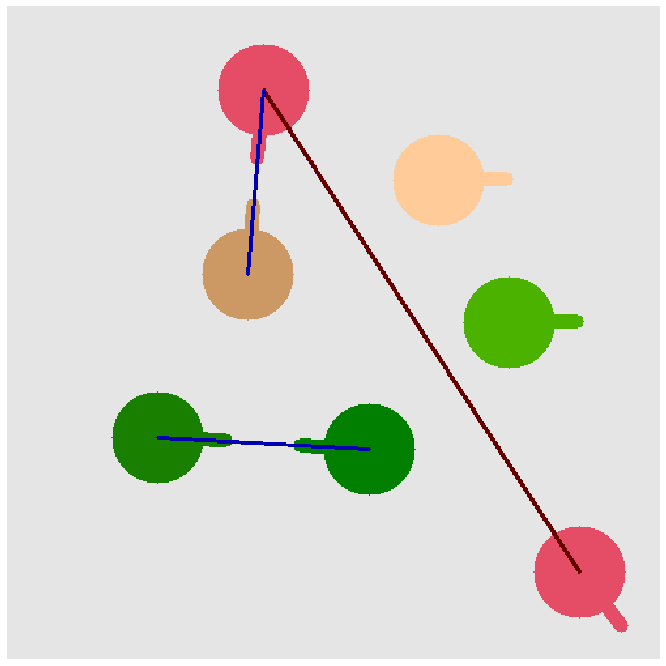

In [593]:
### test scene with new elemnts
#es = [20, 35, 35, 50, 10, 42]
es = [35]
scene = Scene((500, 500), element_class=ColourElement, element_sizes=es)
scene.canvas.fill(0.9)

sets = [(1, 2), (3, 4)]
for i in range(2):
    scene.add_paired_elements(set_id=sets[i])
    
for i in range(3):
    scene.add_element()

    
scene.draw_scene()
scene.show_canvas()

def feature_match_rels(elements):
    centres = []
    for element1 in elements:
        for element2 in elements:
            if element1.id == element2.id:
                continue
            if element1.col == element2.col and element1.size == element2.size:
                centres.append([element1.position, element2.position])
                
    return centres

#print(feature_match_rels(scene.elements))

def draw_lines(scene, centres, col=(0.4, 0, 0)):
    for endpoints in centres:
        cv2.line(scene.canvas, endpoints[0], endpoints[1], color=col, thickness=2)

draw_lines(scene, feature_match_rels(scene.elements))

def draw_rels(scene):
    elems = scene.elements
    rels = scene.relationships
    centres = []
    for rel in rels:
        pos1 = list(filter(lambda e: e.id==rel[0], elems))[0].position
        pos2 = list(filter(lambda e: e.id==rel[2], elems))[0].position
        centres.append((pos1, pos2))
    draw_lines(scene, centres, col=(0.0, 0.0, 0.7))

draw_rels(scene)
scene.show_canvas()
plt.axis('off')
plt.gcf().set_size_inches(12, 12)

[[(370, 158), (457, 57)], [(44, 225), (140, 267)], [(457, 57), (370, 158)], [(129, 453), (234, 436)], [(234, 436), (129, 453)], [(140, 267), (44, 225)]]


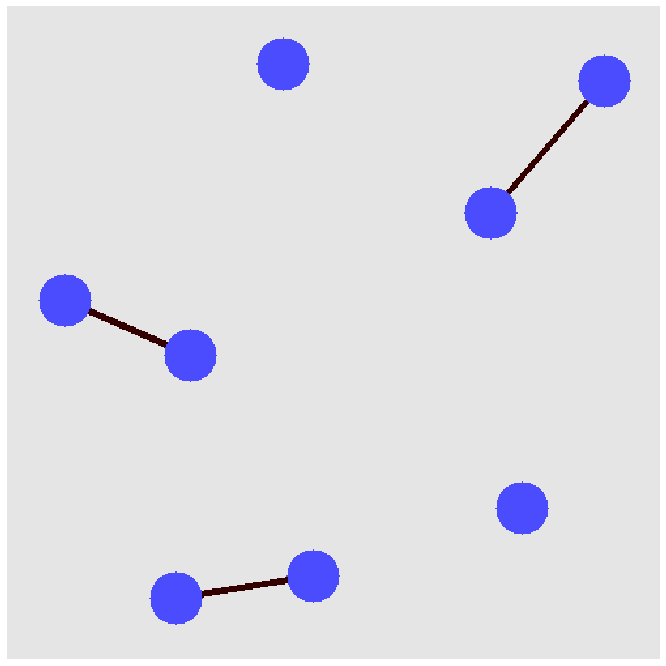

In [348]:
scene = Scene((500, 500), element_class=ColourElement, element_sizes=[20])
scene.canvas.fill(0.9)
for i in range(8):
    scene.add_element()
    
def find_closest_centres(elements):
    centres = []
    for element1 in elements:
        dists = []
        for element2 in elements:
            if element1.id == element2.id:
                continue
            d = (element1.position[1] - element2.position[1])**2 + (element1.position[0] - element2.position[0])**2 
            dists.append((d, [element1.position, element2.position]))
        dists = sorted(dists, key=lambda d: d[0])
        closest = dists[0]
        if closest[0] < 20000:
            centres.append(closest[1])
    return centres

cs = find_closest_centres(scene.elements)
print(cs)

draw_lines(scene, cs)
scene.draw_scene()
scene.show_canvas()
plt.axis('off')
plt.gcf().set_size_inches(12, 12)

In [89]:
### Test the collision detection!
e1 = Element([], [500, 500], sizes=[20])
e2 = Element([e1], [500, 500], sizes=[20])
print(e1.position, e2.position)

(356, 237) (339, 338)


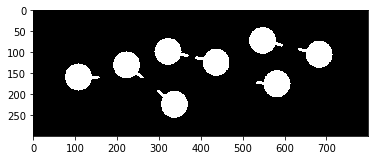

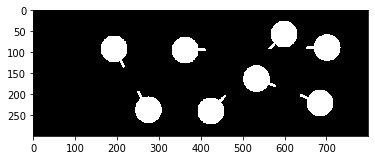

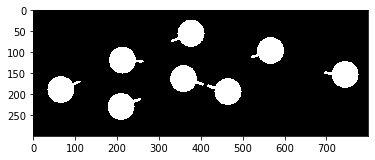

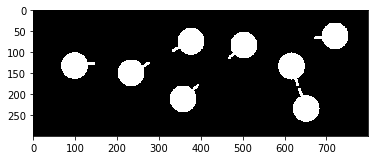

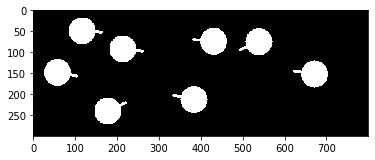

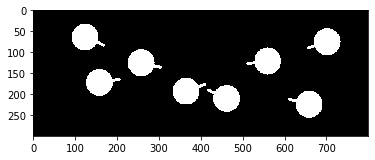

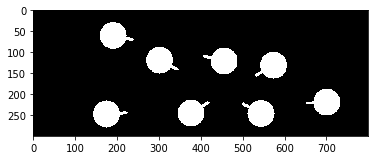

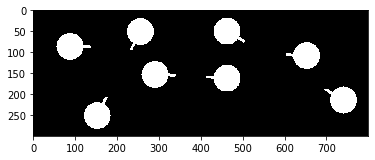

In [24]:
scene = Scene((300,800), element_sizes=[32])
for i in range(8):
    for j in range(4):
        # scene.add_element()
        scene.add_paired_elements()
    scene.draw_scene(bbox=False)
    scene.show_canvas()
    plt.show()
    # print(2*i+1)
    scene.clean_scene()

In [ ]:
def vanilla_and_bucket_generator():
    scene = Scene((500,500), element_sizes=[25])
    for i in range(5):
        scene.add_paired_elements()

### Updates
There is a janky generator
Before polishing this bad boy to provide:
* Pairwise relationships
* Normally distributed position suggestion, based on the previous location
* Noise on the kerls, and the background
* Object classes, and which other classes they like to bond with

I'll work on the network that can use these fake images
I want something which will:
1. take the image
2. Use a pretend RCNN to recover the bounding boxes (with noise..?)
3. Use a GCN to learn the graph structure
4. Propagate the graph structure
5. Predict a missing link??????????

At some point it's important to evaluate it too...

I guess an imporant feature of this synthetic dataset is that a relationship can be classified by the geometry...

Maybe orientations, and distances, should be discretized... or maybe only in the network

The network should learn to predict the parametric relationship... Use the fully supervised training, and the unsupervised training too?

And use that selfie idea... show that self-supervised pretraining can boost performance and lead to better data utilization!!!!!!!

AND THAT IT CAN BE USED FOR GCNs YYAAA
___
Network developments

1. Dataloader <- do this last, it's the easy bit
2. model forward <- yes
3. model networks implementation yeet
4. Loss function <- important to realise what this'll be early on

[(0, (122.77, 0.4017), 1), (1, (122.77, 3.5433), 0), (2, (317.59, 1.2998), 3), (3, (317.59, 4.4414), 2), (4, (249.87, 0.5425), 5), (5, (249.87, 3.6841), 4), (6, (412.99, 1.9477), 7), (7, (412.99, -1.1939), 6), (8, (104.55, 1.9531), 9), (9, (104.55, -1.1885), 8)]


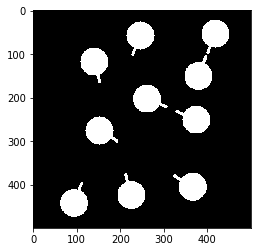

In [59]:
# pairwise test
scene2 = Scene((500,500), element_sizes=[32])
for i in range(5):
    scene2.add_paired_elements()
    #scene2.add_element()
scene2.draw_scene(bbox=False)
scene2.show_canvas()
print(scene2.relationships)

[7, 6, 9, 1, 2, 3, 0, 8, 4, 5]


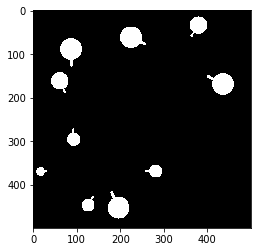

In [486]:
def generate_scene(scene):
    num_elements = 5#np.random.choice(num_elements_allowed)
    # id_set = list(range(num_elements*2))
    id_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    for j in range(num_elements):
        # print(f'ids: {id_set}')
        chosen_id_1 = np.random.choice(id_set)
        id_set.remove(chosen_id_1)
        chosen_id_2 = np.random.choice(id_set)
        id_set.remove(chosen_id_2)
        # print(chosen_id_1, chosen_id_2)        
        scene.add_paired_elements(set_id=(int(chosen_id_1), int(chosen_id_2)))

scene = Scene((500, 500))
generate_scene(scene)
scene.draw_scene()
scene.show_canvas()
print([e.id for e in scene.elements])

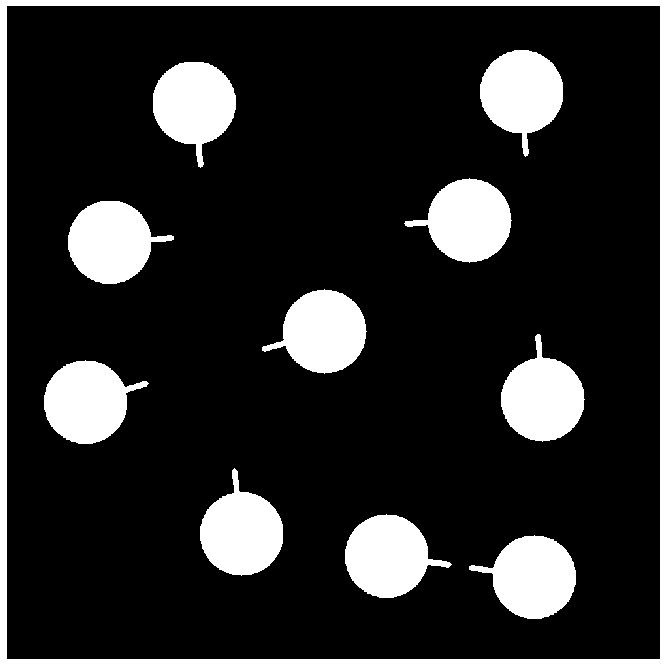

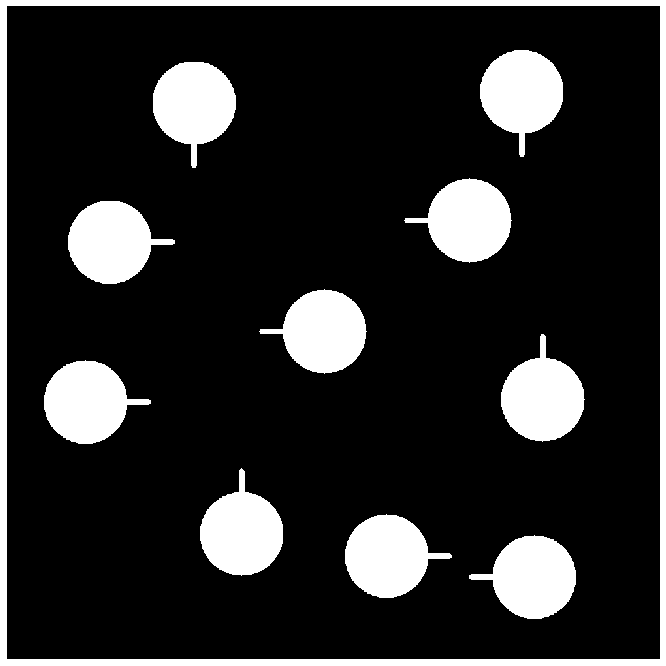

In [610]:
scene = Scene((1000, 1000), element_sizes=[64])
generate_scene(scene)
scene.draw_scene()
plt.axis('off')
scene.show_canvas()
plt.gcf().set_size_inches(12, 12)
plt.show()
# now bucket
import torch # yike
#buckets = torch.tensor([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
buckets = torch.tensor([-1, -0.5, 0, 0.5, 1])
orientation_tensor = torch.tensor([(e.orientation-np.pi/2)/(np.pi) for e in scene.elements])
#print(orientation_tensor.unsqueeze(1))
#print(orientation_tensor.shape)
#print(buckets.repeat(10, 1).shape)
buckets_dist = (buckets.repeat(10, 1) - orientation_tensor.unsqueeze(1)) ** 2
closest_bucket = torch.argmin(buckets_dist, dim=1)
closest_bucket[closest_bucket == 4] = 0
#bucket_onehot = torch.zeros(self.batch_size, self.num_objects, self.nob)
#bucket_onehot = torch.scatter(bucket_onehot, 2, closest_bucket.unsqueeze(2), 1)
#print(closest_bucket)
closest_bucket_vals = torch.gather(buckets[:4], 0, closest_bucket)
#closest_bucket_vals.unsqueeze_(1)
#print(closest_bucket_vals)

for bv, el in zip(closest_bucket_vals.tolist(), scene.elements):
    el.orientation = (bv+0.5)*np.pi
    el._set_nose_tip()
    #print(bv)

scene.clean_canvas()
scene.draw_scene()
scene.show_canvas()
plt.axis('off')
plt.gcf().set_size_inches(12, 12)

In [24]:
def run_scene_generator(n_scenes, output_dir, num_elements_allowed=[5]):
    try:
        os.makedirs(output_dir)
    except FileExistsError as e:
        print(e)
    try:
        os.makedirs(os.path.join(output_dir, 'images'))
    except FileExistsError as e:
        print(e)

    scene = Scene((500,500), output_dir=output_dir, element_sizes=[32])
    scene_dict_list = []
    
    n_fails = 0
    i = 0

    while i < n_scenes:
        if i % 200 == 1:
            print(i-1)
            
        try:
            generate_scene(scene)
            scene.draw_scene()
            scene.save_im(i)
            scene_dict_list.append(scene.get_scene_dict(i))
            i += 1
        except ValueError as e:
            n_fails += 1
            if n_fails % 20 == 0:
                print(f'{n_fails} fails')
            continue
        finally:
            scene.clean_scene()
    
    print(n_fails)
    with open(os.path.join(output_dir, 'scene_info.json'), 'w') as f:
        json.dump(scene_dict_list, f)
        pass
    
    print('done')

In [9]:
# debug sg
run_scene_generator(n_scenes=5, output_dir='sr_fix')

[Errno 17] File exists: 'sr_fix'
[Errno 17] File exists: 'sr_fix/images'
3 1
0 6
7 9
8 4
5 2
0
7 6
9 2
3 1
8 0
4 5
8 1
3 7
5 6
9 2
4 0
7 5
1 4
2 0
6 9
3 8
0 9
4 6
1 8
3 5
2 7
0
done


In [36]:
run_scene_generator(n_scenes=100, output_dir='/Users/i517610/Documents/small_experiments/simple_relation/debug_v/val')
run_scene_generator(n_scenes=4, output_dir='/Users/i517610/Documents/small_experiments/simple_relation/debug_v/train')

[Errno 17] File exists: '/Users/i517610/Documents/small_experiments/simple_relation/debug_v/val'
[Errno 17] File exists: '/Users/i517610/Documents/small_experiments/simple_relation/debug_v/val/images'
0
half a million aint enough yayoo... yerigte


/Users/i517610/.conda/envs/testing_ground/lib/python3.7/site-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in int_scalars


1
done
[Errno 17] File exists: '/Users/i517610/Documents/small_experiments/simple_relation/debug_v/train'
[Errno 17] File exists: '/Users/i517610/Documents/small_experiments/simple_relation/debug_v/train/images'
0
0
done


In [26]:
def make_ll(n_items, f_out):
    bad_list = []
    for a in range(n_items):
        bad_idcs = np.random.permutation(10)
        bad_list.append([int(wut) for wut in list(bad_idcs)])
        
    with open(os.path.join(f_out, 'limiter_list.json'), 'w') as f:
        json.dump(bad_list, f)

In [30]:
#### MASTER GENERATOR
datarootest = '/Users/i517610/Documents/small_experiments/simple_relation/datasets'
dset_name = 'sr5'
dataroot = os.path.join(datarootest, dset_name)
n_train = 12000
n_val = 2000

run_scene_generator(n_train, output_dir=os.path.join(dataroot, 'train'))
run_scene_generator(n_val, output_dir=os.path.join(dataroot, 'val'))
make_ll(n_train, os.path.join(dataroot, 'train'))
make_ll(n_val, os.path.join(dataroot, 'val'))

0
half a million aint enough yayoo... yerigte


/Users/i517610/.conda/envs/testing_ground/lib/python3.7/site-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in int_scalars


half a million aint enough yayoo... yerigte
200
400
600
half a million aint enough yayoo... yerigte
half a million aint enough yayoo... yerigte
800
1000
half a million aint enough yayoo... yerigte
1200
1400
1600
1800
half a million aint enough yayoo... yerigte
half a million aint enough yayoo... yerigte
2000
half a million aint enough yayoo... yerigte
2200
2400
2600
2800
3000
3200
3400
half a million aint enough yayoo... yerigte
3600
3800
half a million aint enough yayoo... yerigte
half a million aint enough yayoo... yerigte
4000
4200
4400
4600
4800
half a million aint enough yayoo... yerigte
half a million aint enough yayoo... yerigte
5000
half a million aint enough yayoo... yerigte
half a million aint enough yayoo... yerigte
5200
5400
half a million aint enough yayoo... yerigte
5600
half a million aint enough yayoo... yerigte
5800
half a million aint enough yayoo... yerigte
half a million aint enough yayoo... yerigte
6000
half a million aint enough yayoo... yerigte
20 fails
6200
half